In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline 
plt.style.use('ggplot')
# Disable Python INFO and WARNING messages
warnings.filterwarnings('ignore')

In [2]:
# Load real estate data 
df = pd.read_csv('data/employee_data.csv')
entries = df.shape[0]
features = df.shape[1]

## 1. Data cleaning

#### Drop unwanted observations

In [4]:
# Drop duplicates observations
df = df.drop_duplicates()
print( 'Removed entries :', entries - df.shape[0] )
print( 'Removed features :', features - df.shape[1] )

Removed entries : 28
Removed features : 0


In [6]:
# Drop irrelevant observations

# Drop temporary workers as observed in the initial exploration step
df = df[df.department != 'temp']
print( 'Removed entries :', entries - df.shape[0] )
print( 'Removed features :', features - df.shape[1] )

Removed entries : 181
Removed features : 0


#### Fix structural errors

In [7]:
#Fix structural errors --  binary indicator variables

#With the numerical features statistics summary done in the initial exploration step we have seen that features 'filed_complaint'
#'recently_promoted' might be binary

# Print unique values of 'filed_complaint'
print( df.filed_complaint.unique() )

# Print unique values of 'recently_promoted'
print( df.recently_promoted.unique() )

[ nan   1.]
[ nan   1.]


They are indeed binary so we must replace 'nan' values with 0 instead for the sake of machine learning modeling.

In [8]:
# Missing filed_complaint values should be 0
df['filed_complaint'] = df.filed_complaint.fillna(0)

# Missing recently_promoted values should be 0
df['recently_promoted'] = df.recently_promoted.fillna(0)

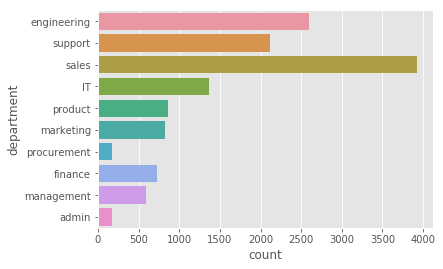

In [9]:
#Fix structural errors --  Mislabeled classes (mostly for categorical features)

# 'information_technology' should be 'IT'
df.department.replace('information_technology', 'IT', inplace=True)

# Plot class distributions for 'department'
sns.countplot(y='department', data=df)

#### Handling missing data

In [10]:
# Display number of missing values by feature
df.isnull().sum()

avg_monthly_hrs         0
department            709
filed_complaint         0
last_evaluation      1351
n_projects              0
recently_promoted       0
salary                  0
satisfaction            0
status                  0
tenure                  0
dtype: int64

In [12]:
# Fill missing values in department with 'Missing' since it is a categorical feature
df['department'].fillna('Missing', inplace=True)

In [14]:
# Flag and fill missing values in last_evaluation since it is a numerical feature 

# Indicator variable for missing last_evaluation 
df['last_evaluation_missing'] = df.last_evaluation.isnull().astype(int)

# Fill missing values in last_evaluation with 0
df.last_evaluation.fillna(0, inplace=True)

In [15]:
# Display number of missing values by feature
df.isnull().sum()

avg_monthly_hrs            0
department                 0
filed_complaint            0
last_evaluation            0
n_projects                 0
recently_promoted          0
salary                     0
satisfaction               0
status                     0
tenure                     0
last_evaluation_missing    0
dtype: int64

## 2. Feature engineering

In the initial exploration step, we identified, through a bivariate segmentation of the employee status with respect to last_evaluation and satisfaction, three clusters of employees who left : 
  
  * **Underperformers**: for last_evaluation < 0.6
  * **Unhappy**: for satisfaction < 0.2 (maybe they are overqualified ?)
  * **Overachiever**: for last_evaluation > 0.8 and satisfaction > 0.7 
        
These clusters can become features we create.

In [17]:
# Create new features
df['underperformer'] = ((df.last_evaluation < 0.6) & 
                        (df.last_evaluation_missing == 0)).astype(int)

df['unhappy'] = (df.satisfaction < 0.2).astype(int)

df['overachiever'] = ((df.last_evaluation > 0.8) & (df.satisfaction > 0.7)).astype(int)

In [18]:
# The proportion of observations belonging to each group
df[['underperformer', 'unhappy', 'overachiever']].mean()

underperformer    0.285257
unhappy           0.092195
overachiever      0.177069
dtype: float64

In [19]:
# Encoding employee status where 'Left' is 1 and 'Employed' is 0
df['status'] = pd.get_dummies( df.status ).Left

# Encoding other categorical features
df = pd.get_dummies(df, columns=['department', 'salary'])

df.head()

avg_monthly_hrs  filed_complaint  last_evaluation  n_projects  \
0              221              0.0         0.932868           4   
1              232              0.0         0.000000           3   
2              184              0.0         0.788830           3   
3              206              0.0         0.575688           4   
4              249              0.0         0.845217           3   

   recently_promoted  satisfaction  status  tenure  last_evaluation_missing  \
0                0.0      0.829896     1.0     5.0                        0   
1                0.0      0.834544     0.0     2.0                        1   
2                0.0      0.834988     0.0     3.0                        0   
3                0.0      0.424764     0.0     2.0                        0   
4                0.0      0.779043     0.0     3.0                        0   

   underperformer  unhappy  overachiever  department_IT  department_Missing  \
0               0        0             1            0.0                 0.0   
1               0        0             0            0.0                 0.0   
2               0        0             0            0.0                 0.0   
3               1        0             0            0.0                 0.0   
4               0        0             1            0.0                 0.0   

   department_admin  department_engineering  department_finance  \
0               0.0                     1.0                 0.0   
1               0.0                     0.0                 0.0   
2               0.0                     0.0                 0.0   
3               0.0                     0.0                 0.0   
4               0.0                     0.0                 0.0   

   department_management  department_marketing  department_procurement  \
0                    0.0                   0.0                     0.0   
1                    0.0                   0.0                     0.0   
2                    0.0                   0.0                     0.0   
3                    0.0                   0.0                     0.0   
4                    0.0                   0.0                     0.0   

   department_product  department_sales  department_support  salary_high  \
0                 0.0               0.0                 0.0          0.0   
1                 0.0               0.0                 1.0          0.0   
2                 0.0               1.0                 0.0          0.0   
3                 0.0               1.0                 0.0          0.0   
4                 0.0               1.0                 0.0          0.0   

   salary_low  salary_medium  
0         1.0            0.0  
1         1.0            0.0  
2         0.0            1.0  
3         1.0            0.0  
4         1.0            0.0

In [20]:
# Save analytical base table
df.to_csv('data/analytical_base_table.csv', index=None)